<a href="https://colab.research.google.com/github/Thiraput01/NLP-sys/blob/main/Week%206/2025_hw6_text_classification_student_model1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# HOMEWORK 6: TEXT CLASSIFICATION
In this homework, you will create models to classify texts from TRUE call-center. There are two classification tasks:
1. Action Classification: Identify which action the customer would like to take (e.g. enquire, report, cancle)
2. Object Classification: Identify which object the customer is referring to (e.g. payment, truemoney, internet, roaming)

We will focus only on the Object Classification task for this homework.

In this homework, you are asked compare different text classification models in terms of accuracy and inference time.

You will need to build 3 different models.

1. A model based on tf-idf
2. A model based on MUSE
3. A model based on wangchanBERTa

**You will be ask to submit 3 different files (.pdf from .ipynb) that does the 3 different models. Finally, answer the accuracy and runtime numbers in MCV.**

This homework is quite free form, and your answer may vary. We hope that the processing during the course of this assignment will make you think more about the design choices in text classification.

In [ ]:
!wget --no-check-certificate https://www.dropbox.com/s/37u83g55p19kvrl/clean-phone-data-for-students.csv

--2025-02-12 09:39:59--  https://www.dropbox.com/s/37u83g55p19kvrl/clean-phone-data-for-students.csv
Resolving www.dropbox.com (www.dropbox.com)... 162.125.13.18, 2620:100:6035:18::a27d:5512
Connecting to www.dropbox.com (www.dropbox.com)|162.125.13.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://www.dropbox.com/scl/fi/8h8hvsw9uj6o0524lfe4i/clean-phone-data-for-students.csv?rlkey=lwv5xbf16jerehnv3lfgq5ue6 [following]
--2025-02-12 09:40:00--  https://www.dropbox.com/scl/fi/8h8hvsw9uj6o0524lfe4i/clean-phone-data-for-students.csv?rlkey=lwv5xbf16jerehnv3lfgq5ue6
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucd3ed4093624d239372836f7171.dl.dropboxusercontent.com/cd/0/inline/Cj9SIonLHrcFFZyluDY-MwnuJWpOtEdBVkCc89XhxA8odxCOiRLEgdGG4u1CAQeVN-WprzW4E-o8hWgbpiHWjI8lQcLR00Tw2wBl7KU49RR3Ks84yFrNEFVrpNghjfMVo7M/file# [following]
--2025-02-12 09:40:00--  https://ucd3ed4093624d239372836

In [ ]:
!pip install pythainlp

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.9/17.9 MB 17.7 MB/s eta 0:00:00


## Import Libs

In [59]:
%matplotlib inline
import pandas
import sklearn
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from torch.utils.data import Dataset
from IPython.display import display
from collections import defaultdict
from sklearn.metrics import accuracy_score

## Loading data
First, we load the data from disk into a Dataframe.

A Dataframe is essentially a table, or 2D-array/Matrix with a name for each column.

In [60]:
data_df = pd.read_csv('clean-phone-data-for-students.csv')

Let's preview the data.

In [61]:
# Show the top 5 rows
display(data_df.head())
# Summarize the data
data_df.describe()

,Sentence Utterance,Action,Object
0,<PHONE_NUMBER_REMOVED> ผมไปจ่ายเงินที่ Counte...,enquire,payment
1,internet ยังความเร็วอยุ่เท่าไหร ครับ,enquire,package
2,ตะกี้ไปชำระค่าบริการไปแล้ว แต่ยังใช้งานไม่ได้...,report,suspend
3,พี่ค่ะยังใช้ internet ไม่ได้เลยค่ะ เป็นเครื่อ...,enquire,internet
4,ฮาโหล คะ พอดีว่าเมื่อวานเปิดซิมทรูมูฟ แต่มันโ...,report,phone_issues


,Sentence Utterance,Action,Object
count,16175,16175,16175
unique,13389,10,33
top,บริการอื่นๆ,enquire,service
freq,97,10377,2525


## Data cleaning

We call the DataFrame.describe() again.
Notice that there are 33 unique labels/classes for object and 10 unique labels for action that the model will try to predict.
But there are unwanted duplications e.g. Idd,idd,lotalty_card,Lotalty_card

Also note that, there are 13389 unqiue sentence utterances from 16175 utterances. You have to clean that too!

## #TODO 0.1:
You will have to remove unwanted label duplications as well as duplications in text inputs.
Also, you will have to trim out unwanted whitespaces from the text inputs.
This shouldn't be too hard, as you have already seen it in the demo.



In [62]:
display(data_df.describe())
display(data_df.Object.unique())
display(data_df.Action.unique())

,Sentence Utterance,Action,Object
count,16175,16175,16175
unique,13389,10,33
top,บริการอื่นๆ,enquire,service
freq,97,10377,2525


array(['payment', 'package', 'suspend', 'internet', 'phone_issues',
       'service', 'nonTrueMove', 'balance', 'detail', 'bill', 'credit',
       'promotion', 'mobile_setting', 'iservice', 'roaming', 'truemoney',
       'information', 'lost_stolen', 'balance_minutes', 'idd',
       'TrueMoney', 'garbage', 'Payment', 'IDD', 'ringtone', 'Idd',
       'rate', 'loyalty_card', 'contact', 'officer', 'Balance', 'Service',
       'Loyalty_card'], dtype=object)

array(['enquire', 'report', 'cancel', 'Enquire', 'buy', 'activate',
       'request', 'Report', 'garbage', 'change'], dtype=object)

In [63]:
# TODO.1: Data cleaning

In [64]:
data_df = data_df[['Sentence Utterance', 'Object']]
data_df.columns = ['input', 'label']

In [65]:
data_df.head()

,input,label
0,<PHONE_NUMBER_REMOVED> ผมไปจ่ายเงินที่ Counte...,payment
1,internet ยังความเร็วอยุ่เท่าไหร ครับ,package
2,ตะกี้ไปชำระค่าบริการไปแล้ว แต่ยังใช้งานไม่ได้...,suspend
3,พี่ค่ะยังใช้ internet ไม่ได้เลยค่ะ เป็นเครื่อ...,internet
4,ฮาโหล คะ พอดีว่าเมื่อวานเปิดซิมทรูมูฟ แต่มันโ...,phone_issues


In [66]:
data_df.label.unique()

array(['payment', 'package', 'suspend', 'internet', 'phone_issues',
       'service', 'nonTrueMove', 'balance', 'detail', 'bill', 'credit',
       'promotion', 'mobile_setting', 'iservice', 'roaming', 'truemoney',
       'information', 'lost_stolen', 'balance_minutes', 'idd',
       'TrueMoney', 'garbage', 'Payment', 'IDD', 'ringtone', 'Idd',
       'rate', 'loyalty_card', 'contact', 'officer', 'Balance', 'Service',
       'Loyalty_card'], dtype=object)

In [67]:
# Clean label
data_df['label']=data_df['label'].str.lower().copy()

In [68]:
data_df.label.unique()

array(['payment', 'package', 'suspend', 'internet', 'phone_issues',
       'service', 'nontruemove', 'balance', 'detail', 'bill', 'credit',
       'promotion', 'mobile_setting', 'iservice', 'roaming', 'truemoney',
       'information', 'lost_stolen', 'balance_minutes', 'idd', 'garbage',
       'ringtone', 'rate', 'loyalty_card', 'contact', 'officer'],
      dtype=object)

In [69]:
data_df.duplicated().sum()

2736

In [70]:
# Drop duplicates
data_df = data_df.drop_duplicates("input", keep='first')

In [71]:
data_df.duplicated().sum()

0

In [72]:
# Create label map
label_2_idx = {l:i for i,l in enumerate(data_df.label.unique())}
idx_2_label = {i:l for l,i in label_2_idx.items()}

In [73]:
data = data_df.to_numpy()
data.shape

(13389, 2)

In [74]:
data[:, 1] = np.vectorize(label_2_idx.get)(data[:,1])
data[:, 1]

array([0, 1, 2, ..., 7, 7, 1], dtype=object)

In [75]:
data[:, 0]

array([' <PHONE_NUMBER_REMOVED> ผมไปจ่ายเงินที่ Counter Services เค้าเช็ต 3276.25 บาท เมื่อวานที่ผมเช็คที่ศูนย์บอกมียอด 3057.79 บาท',
       ' internet ยังความเร็วอยุ่เท่าไหร ครับ',
       ' ตะกี้ไปชำระค่าบริการไปแล้ว แต่ยังใช้งานไม่ได้ ค่ะ', ...,
       'ยอดเงินเหลือเท่าไหร่ค่ะ', 'ยอดเงินในระบบ',
       'สอบถามโปรโมชั่นปัจจุบันที่ใช้อยู่ค่ะ'], dtype=object)

In [76]:
# Trim
def strip_str(string):
    return string.strip()

data[:, 0] = np.vectorize(strip_str)(data[:,0])
data[:, 0]

array(['<PHONE_NUMBER_REMOVED> ผมไปจ่ายเงินที่ Counter Services เค้าเช็ต 3276.25 บาท เมื่อวานที่ผมเช็คที่ศูนย์บอกมียอด 3057.79 บาท',
       'internet ยังความเร็วอยุ่เท่าไหร ครับ',
       'ตะกี้ไปชำระค่าบริการไปแล้ว แต่ยังใช้งานไม่ได้ ค่ะ', ...,
       'ยอดเงินเหลือเท่าไหร่ค่ะ', 'ยอดเงินในระบบ',
       'สอบถามโปรโมชั่นปัจจุบันที่ใช้อยู่ค่ะ'], dtype=object)

#Model 1 TF-IDF

Build a model to train a tf-idf text classifier. Use a simple logistic regression model for the classifier.

For this part, you may find this [tutorial](https://scikit-learn.org/stable/auto_examples/text/plot_document_classification_20newsgroups.html#sphx-glr-auto-examples-text-plot-document-classification-20newsgroups-py) helpful.

Below are some design choices you need to consider to accomplish this task. Be sure to answer them when you submit your model.

What tokenizer will you use? Why?

**Ans:** *newmm because its a to-go for thai sentences*

Will you ignore some stop words (a, an, the, to, etc. for English) in your tf-idf? Is it important?
PythaiNLP provides a list of stopwords if you want to use (https://pythainlp.org/docs/2.0/api/corpus.html#pythainlp.corpus.common.thai_stopwords)

**Ans:** *No, I'll use common.thai_stopwords from pythainlp*

The dictionary of TF-IDF is usually based on the training data. How many words in the test set are OOVs?

**Ans:** *OOV 17215 words, percentage: 52.58%*

## model

In [103]:
from sklearn.feature_extraction.text import TfidfVectorizer
import pythainlp
from sklearn.model_selection import train_test_split
from pythainlp.tokenize import word_tokenize

In [104]:
label = data[:, 1]
X_train, X_test, y_train, y_test = train_test_split(data, label, test_size=0.2, random_state=42)

In [105]:
type(X_train[:, 0][0])

str

In [106]:
X_train = X_train[:, 0]
X_test = X_test[:, 0]

y_train = y_train.astype(int)
y_test = y_test.astype(int)

In [107]:
def custom_tokenizer(text):
    return word_tokenize(text, engine='newmm')

In [108]:
categories = list(np.unique(data[:, 1]))
stop_words = list(set(pythainlp.corpus.common.thai_stopwords()))
tokenizer = word_tokenize

vectorizor = TfidfVectorizer(sublinear_tf=True, max_df=0.5, stop_words=stop_words, tokenizer=custom_tokenizer)
X_train_tokenized = vectorizor.fit_transform(X_train)
X_test_tokenized = vectorizor.transform(X_test)

/usr/local/lib/python3.11/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/feature_extraction/text.py:402: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['กระไร', 'กาลนาน', 'ชิ้น', 'ดังที่', 'ดี', 'ดีกว่า', 'ด้อย', 'ตัว', 'ต่อไป', 'ถัดไป', 'ทั่วถึง', 'ทำ', 'ที่จะ', 'ท่าน', 'ท้าย', 'นา', 'บอ', 'บัด', 'ระยะเวลา', 'ล่ะ', 'วันวาน', 'สม', 'สมบูรณ์', 'สํา', 'หน้า', 'หรับ', 'หา', 'อย', 'เกี่ยว', 'เก่า', 'เดี๋ยวนี้', 'เย็น', 'เล่า', 'เสมือน', 'เหมือนกัน', 'แด่', 'แม้น', 'แหล่', 'โง้น', 'โน้น', 'ใด', 'ไว', 'ไหม', '\ufeff'] not in stop_words.
  warnings.warn(


In [109]:
vectorizor.get_feature_names_out()

array(['\n', '  ', '"', ..., '…', '….', '…..'], dtype=object)

In [110]:
# Extract the vocabulary from the trained TF-IDF model
tfidf_vocab = set(vectorizor.get_feature_names_out())

# Function to find OOV words in test data
def find_oov_words(texts, vocab):
    oov_count = 0
    total_words = 0
    oov_words = set()

    for text in texts:
        tokens = word_tokenize(text, keep_whitespace=False) # Tokenize the text
        total_words += len(tokens)
        for word in tokens:
            if word not in vocab:
                oov_count += 1
                oov_words.add(word)

    return oov_count, total_words, oov_words

# Find OOV words in X_test
oov_count, total_words, oov_words = find_oov_words(X_test, tfidf_vocab)

# Print OOV statistics
print(f"Total words in X_test: {total_words}")
print(f"Number of OOV words: {oov_count}")
print(f"OOV percentage: {100 * oov_count / total_words:.2f}%")
print("Example OOV words:", list(oov_words)[:10])  # Show some OOV words

Total words in X_test: 32740
Number of OOV words: 17215
OOV percentage: 52.58%
Example OOV words: ['เท่าไร', 'ได้ที่', '+7', 'หนึ่ง', 'ขอ', 'ปิยะ', 'สัสดี', 'Youtube', 'iPay', 'โห']


In [111]:
X_train = X_train_tokenized
X_test = X_test_tokenized

In [112]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

model = LogisticRegression(random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("Accuracy: ", accuracy_score(y_test, y_pred))

Accuracy:  0.6766243465272591


Confusion matrix, without normalization
Normalized confusion matrix


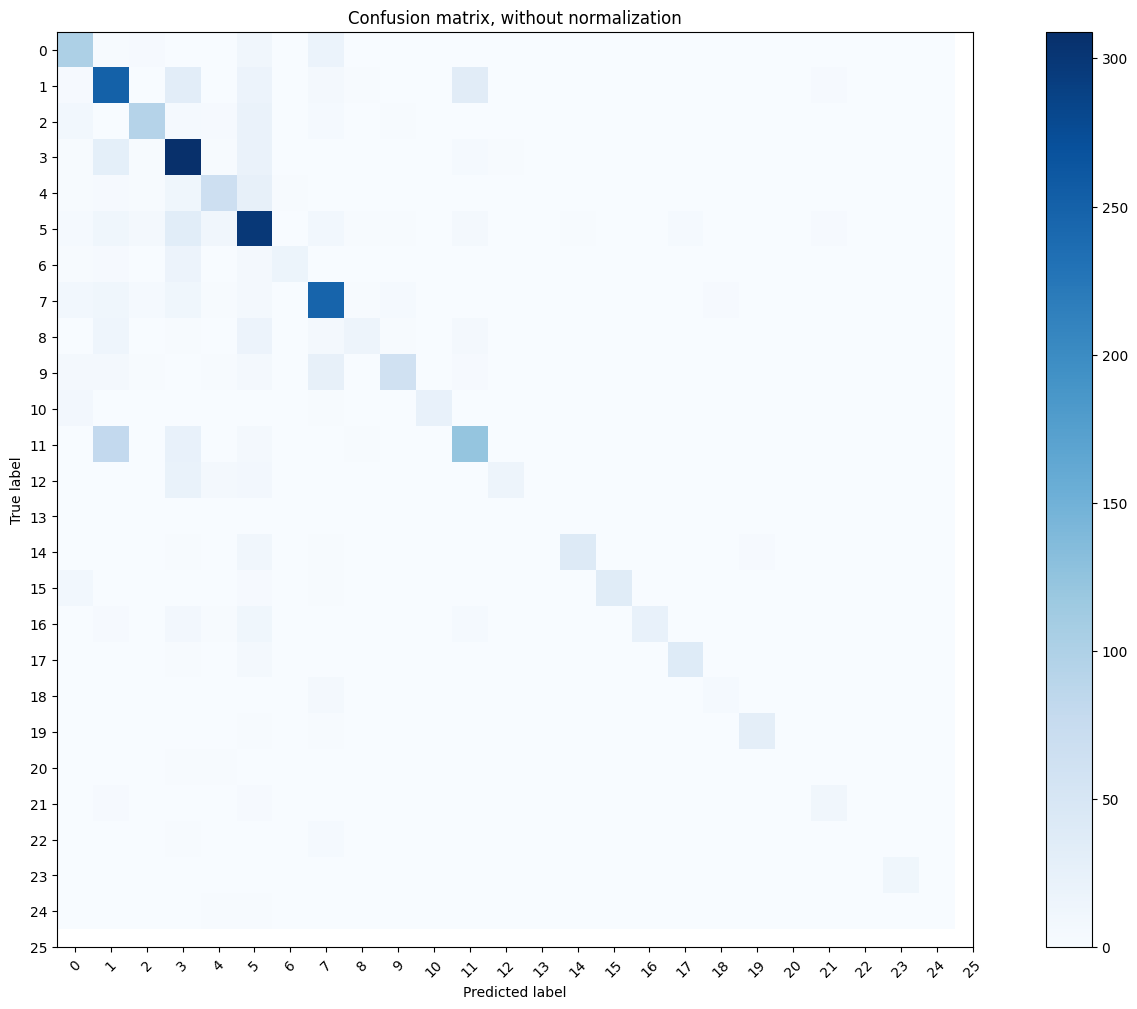

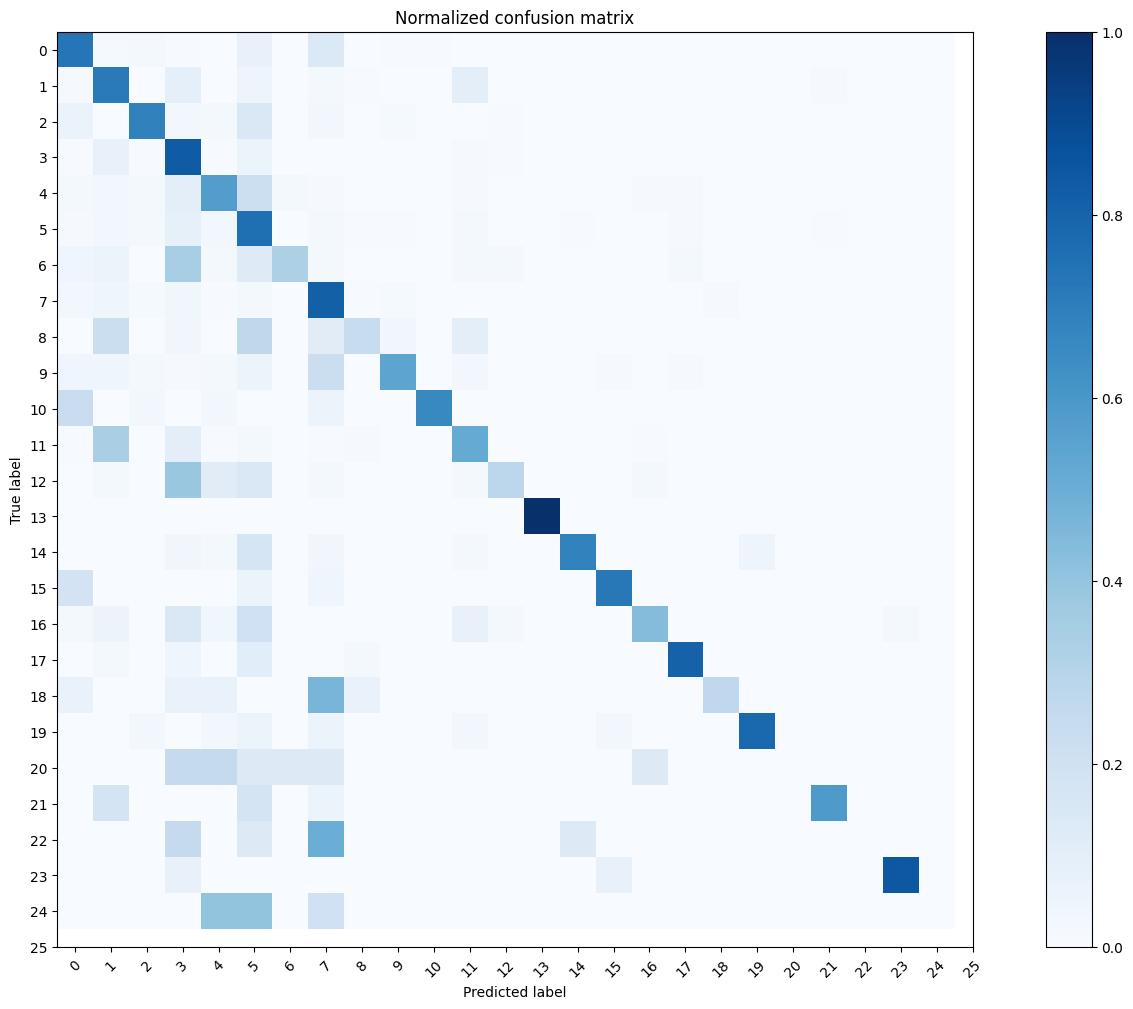

In [97]:
import itertools
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
#     for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
#         plt.text(j, i, format(cm[i, j], fmt),
#                  horizontalalignment="center",
#                  color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


cnf_matrix = confusion_matrix(y_test, y_pred)
# Plot non-normalized confusion matrix
plt.figure(figsize=(15,10))
plot_confusion_matrix(cnf_matrix, classes=categories,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure(figsize=(15,10))
plot_confusion_matrix(cnf_matrix, classes=categories, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

### finding time used

In [98]:
import time

X_train, X_test, y_train, y_test = train_test_split(data, label, test_size=0.2, random_state=42)

X_train = X_train[:, 0]
X_test = X_test[:, 0]

y_train = y_train.astype(int)
y_test = y_test.astype(int)


start_time = time.time()
categories = list(np.unique(data[:, 1]))
stop_words = list(set(pythainlp.corpus.common.thai_stopwords()))
tokenizer = word_tokenize

vectorizor = TfidfVectorizer(sublinear_tf=True, max_df=0.5, stop_words=stop_words, tokenizer=custom_tokenizer)
X_train = vectorizor.fit_transform(X_train)
X_test = vectorizor.transform(X_test)

model = LogisticRegression(random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("Accuracy: ", accuracy_score(y_test, y_pred))
print("Time used: ", time.time() - start_time)

/usr/local/lib/python3.11/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/feature_extraction/text.py:402: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['กระไร', 'กาลนาน', 'ชิ้น', 'ดังที่', 'ดี', 'ดีกว่า', 'ด้อย', 'ตัว', 'ต่อไป', 'ถัดไป', 'ทั่วถึง', 'ทำ', 'ที่จะ', 'ท่าน', 'ท้าย', 'นา', 'บอ', 'บัด', 'ระยะเวลา', 'ล่ะ', 'วันวาน', 'สม', 'สมบูรณ์', 'สํา', 'หน้า', 'หรับ', 'หา', 'อย', 'เกี่ยว', 'เก่า', 'เดี๋ยวนี้', 'เย็น', 'เล่า', 'เสมือน', 'เหมือนกัน', 'แด่', 'แม้น', 'แหล่', 'โง้น', 'โน้น', 'ใด', 'ไว', 'ไหม', '\ufeff'] not in stop_words.
  warnings.warn(


Accuracy:  0.6766243465272591
Time used:  8.54757022857666


# Comparison

After you have completed the 3 models, compare the accuracy, ease of implementation, and inference speed (from cleaning, tokenization, till model compute) between the three models in mycourseville.